2022-08-30 10:11:34.979920 start
Running initial pass
Building Model
Params & Vars established
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from <ipython-
    input-4-74cc1116e232>:346)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from <ipython-
    input-4-74cc1116e232>:353)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from <ipython-
    input-4-74cc1116e232>:360)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from <ipython-
    input-4-74cc1116e232>:383)
    (ordered) position is deprecated.  Please use at()  (deprecated in 6.1,
    will be removed in (or after) 7.0) (called from <ipython-
    input-4-74cc1116e232>:393)
Model Built
Solving...
-6267671.557167619
iMSR was chosen fo

"\nA = main(hrcount = int(87),sites = 'Base4_MSR.csv',lmps = 'SPP_SOUTH_2021.csv',NGCost = 8, MaxMod=2, TES = 200, naics = 324110, EP=10, startHr = 0, dem = 327)\ne = datetime.now()\nprint(e,'end')\nd = e-s\nprint(d)\nQuickGraphOutputs(A.Output,L,'DAM_test2',hr = 72, TES = True)\nWaterfallPlot(A,'TestFull', 'SPP 2021, 327 MWht, 300 C, Full year')\n"

<Figure size 432x288 with 0 Axes>

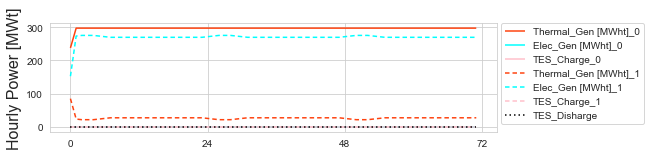

<Figure size 432x288 with 0 Axes>

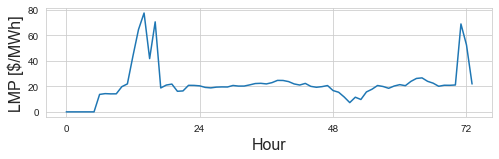

In [4]:
## V23 Streamlining for Greatlakes

## V22 Improving the day-by-day DAM suboptimizations into a whole year rather than full year.
# Adds in initial states into the formulation (lb, ub # mods, reactor gen, elec gen, one/off state)
# Takes a first pass with reduced hours to find the number of modules needed 
# Then fixes the number of modules for each daily optimization (need to add a lower bound of number lb = ub)
# 

## V21 Adding in subsets of the year start date and number of hours

## V20 Adding in the hourly profiles. will do this using the naics code

## V19 Making the script more able to handle the per facility format. Demands in particular are now not a csv which is brough in, but a single hourly value. 06/13/2022

## V18 Dropping the Avoided cost of ff in the objective function. Add in more post process for comparing and analizing revenue breakdown 06/09/2022

## V17 More cleanup

## V16 Cleaning up some constraintes based upon the writing. Making the total charge and discharge for the TES for TES scale not for the modules.

## V15 Making TES paramters optimization -- Lied, did not do that. Just updated some things

## V14 Removing Fast solve as it was far slower. And inputing TES without optimization

## V13 This is a short-cut for resolving results more quickly, by brute force

## V12 Adding the fast solve functionality with solely a float value number of modules option. 
# Adding this possibility on top of current layout to provide layered effect.
# Can run fast, choose best 3, then run full analysis.

## V11 Adding in thermal penalties for coolant to working fluid transfer. 01/21/22
# This is primarily done in the Generator spreadsheet 'sites.csv'
# The Temperature coefficient is 0.75 for all systems currently and are adjusted to occur prior to importing.
# Energy loss to the heat transfer are adjusted to the maximum thermal capacity BUT the electric capacity already accounts for this in the efficiceny therefore it is only applied to the pTCap value.

## V10 Fixing the MSL for thermal baseline issue.
# This means that the vTGen is now the total thermal generation from the 'boiler' aspect of the cycle.
# vGen remains unchanged
# The thermal demand for the facility is satisfied by (vTGen-vGen/pEff)
# This allows for the system to have a more specific link between the thermal requirements of the nuclear reactor itself which has a distinct ramping and range
# and for the electricicty to behave a certain way without tryign to directly couple them in vTGenabovemin which would provide complications if the 
# vTGen were simply the heat to industry.
# new value is put into the results vHeatGen which is the MWht for the supplied industrial heating.
# this opens the question is the pTVOC is solely the thermal cycle and if the pVOC is just to operate the turbine and generate electricty outside of the thermal behavior.

import pandas as pd
import numpy as np
import cplex
import os

import matplotlib.pyplot as plt
import seaborn as sns
import math

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

import pyomo.environ as pe
import pyomo.opt
from pyomo.opt import SolverStatus

from datetime import datetime
s = datetime.now()
print(s,'start')


import Facility_Processing_2015 as FP

class EconomicAssessment_OneGen:
    def __init__(self):
        
        self.Generator_IDs = None             # Names of the egenrators being evaluated
        
        #### sets ####
        self.G = None                         # Generator indexes [0,1,2....]
        self.T = None                         # Timestep indexes [0,1,2....8759]
        self.M = None #list(range(6))              # Maximum number of modules for any generator
        #self.YR = None                        # Number of years
        
        #### paramteres ####
        
        # Environmental paramters/System
        self.pLMP = None                      # LMP electric $MWhe [t] or [t,yr]
        #self.pTLMP = None                     # LMP heat $/MWht [g,t] or [t,yr]
        self.pTempdemanded = None             # Minimum temperature which the reactor must supply for the given TLMP single value
        self.pTEnergyDemand = None            # Thermal energy required per hour in MWt [t]
        
        # Engineering parameters for generators
        self.pOnoroffinitial = None           # initial state, default, 1 = On [g]
        self.pStartupfixedcost = None         # $/MW [g]
        self.pVOC = None                      # Variable O&M ($/MWhe) [g]
        self.pTVOC = None                     # Variable O&M ($/MWht) [g]
        self.pCap = None                      # Maximum Electric capacity MWe == pTCap*ThermalEff [g]
        self.pTCap = None                     # Maximum Thermal capacity MWt [g]
        self.pThermaleff = None               # Thermal efficiency [g]
        self.pThermaTransfereff = None        # V11 Thermal transsfer efficicnecy between coolant and workign fluid.
        self.pMSL = None                      # Minimum stable thermal load (MWt) [g]
        self.pMSLTurb = None                  # Minimum stable trubine load minumum core + turbine power [g]
        self.pMDT = None                      # Minimum down time (hours) [g]
        self.pGenabovemininitial = None       # Initial generation above the min (MWe) [g]
        self.pRGenInitial = None              # Initial generation of reactor (MWth) [g]
        self.pRamprate = None                 # Maximum ramp (up and down) (MW/hr) [g]
        
        self.pCAPEX = None                    # Capital costs of the generator $/MWe [g]
        self.pFOPEX = None                    # Fixed O&M costs of the generator $/MWe [g]
        self.pModulesize = None               # Module size in MWe [g]
        self.pOutlettemp = None               # SMR outlet temperature [g]
        self.pWorkingTemp = None              # SMR working fluid temp 
        self.pMaxMod = None                   # maximum number of modules [g]
        self.pMinMod = None                   # minimum number of modules [g] V222 71522    
        
        self.pIR = 0.07                       # Discount/ Interest Rate 7% (OMB Circular)
        self.pLifetime = 30                   # Lifetime, years
        
        # V14 Additions MV 3/1/2022
        ## TES Parameters ####
        self.pTESCapacity = None              # Storage thermal capacity (MWh-thermal)
        self.pTESChargeEff = None             # Charging Efficiency (%) 
        self.pTESDischargeEff = None          # Discharging Efficicency (%) 
        self.pTESLossRate = None              # Rate at which the stored thermal energy is lost (%/hr)
        self.pTESPowerCap = None              # Power in or out maximum (MWt)
        
        ## TES Variables #### 
        self.vTESSOC = None                   # TES State of Charge (MWht)
        self.vTESSOC_Charge = None            # TES Charge amount (MWht)
        self.vTESSOC_Discharge = None         # TES Discharge amount (MWht)
        # V15
        self.vTESCapacity = None              # DV of the total storage (MWht)
        self.vTESPowerCap = None              # DV of CHarge/Discharge Power (MWt)
        # V22 
        self.pTESInitSOC = None               # Start SOC of TES (MWht)
        self.pTES_Ch0 = None
        self.pTES_Dis0 = None
        #### variables ####
        
        # Float variables
        self.vGen = None                      # Electric generation (MWhe) [g,t] --> [t]
        self.vTGen = None                     # Heat generation (MWht) [g,t] --> [t]
        self.vGenabovemin = None              # Electric generation above the MSLTurb (MWhe) [m,t]
        self.vTGenabovemin = None             # Thermal Generation above MSL (MWht) [m,t]
        
        # Binary variables
        self.vTurnon = None                   # Does the generator turn on (1) or not (0) [m,t] --> [t]
        self.vTurnoff = None                  # Gnerator turns off(1) or not (0) at time t [m,t] --> [t]
        self.vOnoroff = None                  # Generator state at time t [m,t] --> [t]
        self.vEOnoroff = None                 # Electricity generation on (1) or off (0) [m,t] --> [t]
        self.vTOnoroff = None                 # Heat generation on (1) or off (0) [m,t] --> [t]
        
        # results/objective variables  --These are not explicit model components and ar calculated from other variable values
        self.rEProfit = None                  # Profits from vGen*LMP [m,t]
        self.rTProfit = None                  # Profits from vTgen*TLMP [m,t]
        self.rProfit = None                   # Hourly profits ($) [m,t]
        
        self.vTotalProfits = None             # Total Profits ($) [-] single value
        self.rFeasible = None                 # is this configurations feasible     
        
        self.vGenerator = None                # Index of the generator chosen for the
        
        #V18 
        self.rACC = None                      # Annualized capital cost
        self.rFOMC = None                     # Fixed cost
        self.rVC = None                       # Variable cost
        self.rFC = None                       # Fuel cost
        self.rEP = None                       # Electricity profit
        self.rAVC = None                      # Avoided cost of natural gas
        self.rSUC = None                      # Startup costs
        self.rTES = None                      # TES CAPEX
        self.RampCost = 1.0
        
        
    def BuildModel(self, DAM = False):
        pTS = []
        for i in range(len(self.G)):
            if self.pOutlettemp[i] >= self.pTempdemanded:
                pTS.append(1)
            else:
                pTS.append(0)
            
        self.pThermalSat = pTS
        
        if not DAM:
            print('Building Model')
        model = pe.ConcreteModel()
        
        #### SETS ####     
        
        model.G = pe.Set(initialize = self.G, doc = "Generator IDs")
        model.T = pe.Set(initialize = self.T, doc = "Timestep")
        model.M = pe.Set(initialize = self.M, doc = "Modules")
        #model.YR = pe.Set(initialize = self.YR, doc = 'Years of model runs-- CURRENTLY NOT USED')
        
        
        #### PARAMETERS ####
        
        model.pLMP = pe.Param(model.T,initialize = {self.T[i]: self.pLMP[i] for i in range(len(self.T))} , doc = "LMP Electric $/MWhe")
        #model.pTLMP = pe.Param(model.G, model.T,initialize = self.pTLMP, doc = "LMP Thermal $/MWht")
        model.pTEnergyDemand = pe.Param(model.T,initialize = {self.T[i]: self.pTEnergyDemand[i] for i in range(len(self.T))} , doc = "Energy demand MWht")
        
        model.pOnoroffinitial = pe.Param(model.M,initialize = {self.M[i]: self.pOnoroffinitial[i] for i in range(len(self.M))}, doc = "Inital state, 1 on, 0 off")
        model.pStartupfixedcost = pe.Param(model.G,initialize = {self.G[i]: self.pStartupfixedcost[i] for i in range(len(self.G))}, doc = "Startup costs, $500 default")
        #model.pVOC = pe.Param(model.G,initialize = {self.G[i]: self.pVOC[i] for i in range(len(self.G))}, doc = "Variable O&M Electric $/MWhe")
        model.pTVOC = pe.Param(model.G,initialize = {self.G[i]: self.pTVOC[i] for i in range(len(self.G))}, doc = "Variable O&M Thermal $/MWhe")
        model.pCap = pe.Param(model.G,initialize = {self.G[i]: self.pCap[i] for i in range(len(self.G))} , doc = "Maximum Electric Capacity MWe")
        model.pTCap = pe.Param(model.G,initialize = {self.G[i]:self.pTCap[i] for i in range(len(self.G))}, doc = "Maximum Thermal Capacity MWt")
        model.pThermaleff = pe.Param(model.G,initialize = {self.G[i]: self.pThermaleff[i] for i in range(len(self.G))}, doc = "Thermal efficiency (MWe/MWt)")
        model.pThermalTransfereff = pe.Param(model.G,initialize = {self.G[i]: self.pThermaTransfereff[i] for i in range(len(self.G))}, doc = "Thermal transfer efficiency (MW -coolant/MWt- working fluid)")
        model.pMSL = pe.Param(model.G,initialize = {self.G[i]: self.pMSL[i] for i in range(len(self.G))}, doc = "Minimum Stable Load Thermal MWt")
        model.pMSLTurb = pe.Param(model.G,initialize = {self.G[i]: self.pMSLTurb[i] for i in range(len(self.G))}, doc = "Minimum Stable Load of Turbine MWe")
        model.pMDT = pe.Param(model.G,initialize = {self.G[i]: self.pMDT[i] for i in range(len(self.G))} , doc = "Mimimum Down time (hours)")
        #model.pGenabovemininitial = pe.Param(model.M,initialize = {self.M[i]: self.pGenabovemininitial[i] for i in range(len(self.M))}, doc = "Initial Generation above the Minimun MWe")
        model.pRGenInitial = pe.Param(model.M,initialize = {self.M[i]: self.pRGenInitial[i] for i in range(len(self.M))}, doc = "Initial Generation MWt")
        model.pRamprate = pe.Param(model.G,initialize = {self.G[i]: self.pRamprate[i] for i in range(len(self.G))}, doc = "Ramp rate up and down MW/hr")        
        model.pFOPEX = pe.Param(model.G,initialize = {self.G[i]: self.pFOPEX[i] for i in range(len(self.G))}, doc = "FOPEX pparamter $/MWe")
        model.pCAPEX = pe.Param(model.G,initialize = {self.G[i]: self.pCAPEX[i] for i in range(len(self.G))}, doc = "CAPEX values$/MWe")
        model.pWorkingTemp = pe.Param(model.G,initialize = {self.G[i]: self.pWorkingTemp[i] for i in range(len(self.G))}, doc = "working temperature which the reactor can supply in Degrees C")
        model.pThermalSat  = pe.Param(model.G,initialize = {self.G[i]: self.pThermalSat[i] for i in range(len(self.G))}, doc = "SMR can supply the temperature")
        model.pMaxMod = pe.Param(model.G, initialize = {self.G[i]: self.pMaxMod[i] for i in range(len(self.G))}, doc = "maximum number of modules")
        #V22 MV 7/15/2022
        model.pMinMod = pe.Param(model.G, initialize = {self.G[i]: self.pMinMod[i] for i in range(len(self.G))}, doc = "maximum number of modules")
        model.pTESInitSOC = pe.Param(model.G, initialize = {self.G[i]: self.pTESInitSOC[i] for i in range(len(self.G))}, doc = "initial SOC")
        if DAM:
            model.pTES_Ch0 = pe.Param(model.G, initialize = {self.G[i]: self.pTES_Ch0[i] for i in range(len(self.G))}, doc = "initial charge DAM")
            model.pTES_Dis0 = pe.Param(model.G, initialize = {self.G[i]: self.pTES_Dis0[i] for i in range(len(self.G))}, doc = "initial discharge DAM")

        
        # V14 Additions MV 3/1/2022
        model.pTESCapacity = pe.Param(model.G,initialize = {self.G[i]: self.pTESCapacity[i] for i in range(len(self.G))}, doc = "TES max storage")
        model.pTESChargeEff = pe.Param(model.G,initialize = {self.G[i]: self.pTESChargeEff[i] for i in range(len(self.G))}, doc = "TES Charge Efficiency")
        model.pTESDischargeEff = pe.Param(model.G,initialize = {self.G[i]: self.pTESDischargeEff[i] for i in range(len(self.G))}, doc = "TES Discharge Efficiency")
        model.pTESLossRate = pe.Param(model.G,initialize = {self.G[i]: self.pTESLossRate[i] for i in range(len(self.G))}, doc = "TES Loss Rate if just sitting")
        model.pTESPowerCap = pe.Param(model.G,initialize = {self.G[i]: self.pTESPowerCap[i] for i in range(len(self.G))}, doc = "Maximum power in or out of stroage")
        
        #### VARIABLES ####
        model.vGenerator = pe.Var(model.G,within=pe.Binary,doc = "Choice of generator")
        model.vModuleS = pe.Var(model.G,model.M,within = pe.Binary, doc = "choice of modules for full optimization")
        
        model.vGen = pe.Var(model.G,model.M,model.T,within=pe.NonNegativeReals, doc = "Electric generation (MWhe)")
        model.vTGen = pe.Var(model.G,model.M,model.T,within=pe.NonNegativeReals, doc = " Heat generation (MWht) ")
        model.vRGen = pe.Var(model.G,model.M,model.T,within=pe.NonNegativeReals, doc = " Total Reactor generation (MWht) ")
        
        model.vGenabovemin = pe.Var(model.G,model.M,model.T,within=pe.NonNegativeReals, doc = "Electric generation above the MSLTurb (MWhe)")
        model.vRGenabovemin = pe.Var(model.G,model.M,model.T,within=pe.NonNegativeReals, doc = "Thermal Generation above MSL (MWht)")
        
        model.vTurnon = pe.Var(model.G,model.M,model.T,within=pe.Binary, doc = "Does the generator turn on (1) or not (0)")
        model.vTurnoff = pe.Var(model.G, model.M,model.T,within=pe.Binary, doc = "Generator turns off(1) or not (0) at time t")
        model.vOnoroff = pe.Var(model.G,model.M,model.T,within=pe.Binary, doc = "Generator state at time t")
        model.vEOnoroff = pe.Var(model.G,model.M,model.T,within=pe.Binary, doc = "Electricity generation on (1) or off (0)")
        model.vTOnoroff = pe.Var(model.G,model.M,model.T,within=pe.Binary, doc = "Heat generation on (1) or off (0)")
        
        # V14 Additions MV 3/1/2022
        model.vTESSOC = pe.Var(model.G,model.T,within=pe.NonNegativeReals, doc = "TES State of Charge")
        model.vTESSOC_Charge = pe.Var(model.G,model.M,model.T,within=pe.NonNegativeReals, doc = "TES SOC charge")
        model.vTESSOC_Discharge = pe.Var(model.G,model.T,within=pe.NonNegativeReals, doc = "TES SOC charge")
        
        # V15 
        #model.vTESCapacity = pe.Var(model.G,within=pe.NonNegativeReals, doc = "DV of TES Capacity")
        #model.vTESPowerCap = pe.Var(model.G,within=pe.NonNegativeReals, doc = "DV of TES Power Charge/Discharge")
        
        if not DAM:
            print('Params & Vars established')
        
        
        #### OBJECTIVES ####
        
        def ERevenues(model):
            return sum(sum(sum(model.vGen[g,m,t]*model.pLMP[t]for g in model.G) for m in model.M) for t in model.T)
        
        #def TRevenues(model):
        #    return sum(sum((sum(model.vTGen[g,m,t] for m in model.M)+ model.vTESSOC_Discharge[g,t]*model.pTESDischargeEff[g])*model.pTLMP[g,t] for g in model.G) for t in model.T)
        
        def RampCost(model):
            return sum(sum(sum((((model.vRGenabovemin[g,m,model.T.prevw(t)])-(model.vRGenabovemin[g,m,t]))**2)*self.RampCost for t in model.T) for m in model.M) for g in model.G)
        
        def Costs(model):
            return (sum(model.pStartupfixedcost[g]*sum(sum(model.vTurnon[g,m,t] for t in model.T) for m in model.M) for g in model.G) 
                    + sum(sum(sum((model.vRGen[g,m,t]*model.pTVOC[g]) for g in model.G) for m in model.M) for t in model.T) 
                    + sum(sum(model.pCap[g]*(model.pCAPEX[g]*model.vModuleS[g,m]*(self.pIR/(1-((1+self.pIR)**(-1*self.pLifetime))))+model.pFOPEX[g]*model.vModuleS[g,m]) for m in model.M) for g in model.G)*(len(self.T)/8760)
                    + sum(model.vGenerator[g]*model.pTESCapacity[g]*self.pTESCapex*(self.pIR/(1-((1+self.pIR)**(-1*self.pLifetime))))*(len(self.T)/8760) for g in model.G))
        
        
        def Obj_Profit(model):
            return ERevenues(model)-Costs(model)-RampCost(model) # +TRevenues(model)
        model.Obj_Profit = pe.Objective(rule = Obj_Profit, sense=pe.maximize, doc = "Maximize the profits by balancing thermal and electric generation")
                

        #### CONSTRAINTS ####
        
        model.GeneratorChooser = pe.Constraint(expr = sum(model.vGenerator[g] for g in model.G)<=1)
        model.ModChooserS = pe.Constraint(expr = sum(sum(model.vModuleS[g,m] for g in model.G)for m in model.M)>=1)

        def ThermalEquality(model,t):
            return sum(sum(model.vTGen[g,m,t] for m in model.M) + model.vTESSOC_Discharge[g,t]*model.pTESDischargeEff[g] for g in model.G) == model.pTEnergyDemand[t]
        model.ThermalEquality = pe.Constraint(model.T, rule = ThermalEquality, doc = "Limits the thermal output (and therefore the 'revenue from heat')")
        
        def ModuleLimit(model,g):
            return sum(model.vModuleS[g,m] for m in model.M) <= model.pMaxMod[g]
        model.ModuleLimit = pe.Constraint(model.G,rule = ModuleLimit, doc = "limits the number of available modules")
        
        def ModuleLimitLower(model,g):
            return sum(model.vModuleS[g,m] for m in model.M) >= model.pMinMod[g]
        model.ModuleLimitLower = pe.Constraint(model.G,rule = ModuleLimitLower, doc = "limits the lower number of available modules")
        
        def ModGenS(model,g,m):
            return model.vModuleS[g,m] <= model.vGenerator[g]
        model.ModGenS = pe.Constraint(model.G,model.M,rule = ModGenS, doc = "cannot build modules for the non-optimal gens Slow")
        
        def ModStatus(model,g,m,t):
            return model.vOnoroff[g,m,t] <= model.vModuleS[g,m]
        model.ModStatus = pe.Constraint(model.G,model.M, model.T, rule = ModStatus, doc = "The status of the plant must be the previous state plus the turnon/off")
        
        def ECapacityLimit(model,g,m,t):
            return model.vGen[g,m,t] <= model.pCap[g]
        model.ECapacityLimit = pe.Constraint(model.G,model.M,model.T,rule = ECapacityLimit, doc = "The sum of the electric generation must not surpass maximum generation")
        
        def RGenEquality(model,g,m,t):
            return (model.vTGen[g,m,t] + model.vGen[g,m,t]/model.pThermaleff[g] + 
                    model.vTESSOC_Charge[g,m,t]/model.pTESChargeEff[g]) == model.vRGen[g,m,t]*model.pThermalTransfereff[g] # Updated V14 MV 03012022
        model.RGenEquality = pe.Constraint(model.G,model.M,model.T,rule = RGenEquality, doc = "electricity and thermal must equal ttoal")
        
        def EStatus(model,g,m,t): 
            return model.vEOnoroff[g,m,t] <= model.vOnoroff[g,m,t]
        model.Estatus = pe.Constraint(model.G,model.M,model.T, rule = EStatus, doc = "The electric generation cannot be on when the overall status is off")
        
        def Estatus2(model,g,m,t):
            return model.vGen[g,m,t] <= model.pCap[g]*model.vEOnoroff[g,m,t]
        model.Estatus2 = pe.Constraint(model.G,model.M,model.T,rule = Estatus2, doc = "The sum of the electric generation must not surpass maximum generation")
        
        def RStatus(model,g,m,t):
            return model.vRGen[g,m,t]*model.pThermaleff[g]<= model.pCap[g]*model.vOnoroff[g,m,t]
        model.RStatus = pe.Constraint(model.G,model.M,model.T,rule = RStatus, doc = "The sum of the electric and thermal generation must not surpass maximum generation")
        
        def TAllow(model,g,m,t):
            return model.vOnoroff[g,m,t] <= model.pThermalSat[g]
        model.TAllow = pe.Constraint(model.G,model.M,model.T, rule = TAllow, doc = "Must satisfty heat constraint")
        
        def RGenAbove(model,g,m,t):
            return model.vRGenabovemin[g,m,t]  == ((model.vRGen[g,m,t])-(((model.pMSL[g])/model.pThermaleff[g])*model.vOnoroff[g,m,t]))
        model.RGenAbove = pe.Constraint(model.G,model.M,model.T, rule = RGenAbove, doc = "This defines the generation above the minimum stable load")
        
        def EGenAbove(model,g,m,t):
            return model.vGenabovemin[g,m,t]  == (model.vGen[g,m,t]-(model.pMSLTurb[g]*model.vEOnoroff[g,m,t]))
        model.EGenAbove = pe.Constraint(model.G,model.M,model.T, rule = EGenAbove, doc = "This defines the generation above the minimum stable load")
        
        def RRamprateUp(model,g,m,t):
            if t == model.T[1]: 
                return (model.pRGenInitial[m])-(model.vRGenabovemin[g,m,t]) >= -1*model.pRamprate[g]/(model.pThermaleff[g])
                #return pe.Constraint.Feasible # V11C THis means that we can start iur reactor at any output.
            return (model.vRGenabovemin[g,m,model.T.prev(t)])-(model.vRGenabovemin[g,m,t]) >= -1*model.pRamprate[g]/(model.pThermaleff[g])
        model.RRamprateUp = pe.Constraint(model.G,model.M,model.T, rule = RRamprateUp, doc = "The hourly change must not exceed the ramprate between time steps")
        
        def RRamprateDn(model,g,m,t):
            if t == model.T[1]:
                return ((model.pRGenInitial[m])-(model.vRGenabovemin[g,m,t]))*(model.pThermaleff[g]) <= model.pRamprate[g]
                #return pe.Constraint.Feasible # V11C THis means that we can start iur reactor at any output.
            return (model.vRGenabovemin[g,m,model.T.prev(t)]-model.vRGenabovemin[g,m,t])*(model.pThermaleff[g]) <= model.pRamprate[g]
        model.RRamprateDn = pe.Constraint(model.G,model.M,model.T, rule = RRamprateDn, doc = "The hourly change must not exceed the ramprate between time steps")
        ''''''
        def Status(model,g,m,t):
            if t == model.T[1]:
                #return pe.Constraint.Feasible
                return model.vOnoroff[g,m,t] == (model.pOnoroffinitial[m]+ model.vTurnon[g,m,t] - model.vTurnoff[g,m,t])
            return model.vOnoroff[g,m,t] == (model.vOnoroff[g,m,model.T.prev(t)] + model.vTurnon[g,m,t] - model.vTurnoff[g,m,t])
        model.Status = pe.Constraint(model.G,model.M, model.T, rule = Status, doc = "The status of the plant must be the previous state plus the turnon/off")
        
        def SingleGenStatus(model,g,m,t):
            return model.vOnoroff[g,m,t] <= model.vGenerator[g]
        model.SingleGenStatus = pe.Constraint(model.G,model.M, model.T, rule = SingleGenStatus, doc = "The status of the plant must be the previous state plus the turnon/off")
        '''
        def TurnOn(model,g,m,t):
            if t == model.T[1]:
                return model.vTurnon[g,m,t] == (model.vOnoroff[g,m,t]-model.pOnoroffinitial[g] + model.vTurnoff[g,m,t])
            return model.vTurnon[g,m,t] == (model.vOnoroff[g,m,t]-model.vOnoroff[g,m,model.T.prev(t)] + model.vTurnoff[g,m,t])
        model.TurnOn = pe.Constraint(model.G,model.M,model.T, rule = TurnOn, doc = "Ensure turn on variable goes from off to on states")
        
        def TurnOff(model,g,m,t):
            if t == model.T[1]:
                return model.vTurnoff[g,m,t] == (model.pOnoroffinitial[g] - model.vOnoroff[g,m,t] + model.vTurnon[g,m,t])
            return model.vTurnoff[g,m,t] == model.vOnoroff[g,m,model.T.prev(t)] - model.vOnoroff[g,m,t] + model.vTurnon[g,m,t]
        model.TurnOff = pe.Constraint(model.G,model.M,model.T, rule = TurnOff, doc = "Ensure turn off variable goes from on to off states")
        '''
        def MinDownTime(model,g,m,t):
            if t == model.T[1]:
                return pe.Constraint.Feasible
            if t <= model.pMDT[g]:
                return sum((1-model.vOnoroff[g,m,model.T.prev(t,td+1)]) for td in range(t)) >= t*model.vTurnon[g,m,t]
            return sum((1-model.vOnoroff[g,m,model.T.prev(t,td+1)]) for td in range(model.pMDT[g])) >= model.pMDT[g]*model.vTurnon[g,m,t]
        model.MinDownTime = pe.Constraint(model.G,model.M,model.T, rule = MinDownTime, doc = "We must enforce minimum down time")
        
        # V14 Updates
        
        def TES_SOC(model,g,t):
            if t == model.T[1]:
                if DAM == True:
                    return model.vTESSOC[g,t] == (model.pTESInitSOC[g]*(1-model.pTESLossRate[g]) 
                                      - model.pTES_Dis0[g] + model.pTES_Ch0[g])
                else:
                    return model.vTESSOC[g,t] == model.pTESInitSOC[g]
            return model.vTESSOC[g,t] == (model.vTESSOC[g,model.T.prev(t)]*(1-model.pTESLossRate[g]) 
                                          - model.vTESSOC_Discharge[g,model.T.prev(t)]
                                          + sum(model.vTESSOC_Charge[g,m,model.T.prev(t)] for m in model.M))
        model.TES_SOC = pe.Constraint(model.G,model.T, rule = TES_SOC, doc = "SOC is equal to the in/out plus the previous step with losses.")
        
        def TES_SOC_Max(model,g,t):
            return model.vTESSOC[g,t] <= model.pTESCapacity[g]
        model.TES_SOC_Max = pe.Constraint(model.G,model.T, rule = TES_SOC_Max, doc = "SOC has to be below the capacity limit")
        
        def TES_SOC_Power(model,g,t):
            return model.vTESSOC_Discharge[g,t] <= model.pTESPowerCap[g]
        model.TES_SOC_Power = pe.Constraint(model.G, model.T, rule = TES_SOC_Power, doc = "TES cannot surpass the power out max")
        
        def TES_SOC_Power2(model,g,t):
            return sum(model.vTESSOC_Charge[g,m,t]for m in model.M) <= model.pTESPowerCap[g]
        model.TES_SOC_Power2 = pe.Constraint(model.G, model.T, rule = TES_SOC_Power2, doc = "TES cannot surpass the power out max")
        
        self.model = model
        if not DAM:
            print('Model Built')
        
        
    def SolveModel(self, solver='cplex_direct', DAM = False):
        self.BuildModel(DAM = DAM)
        if not DAM:
            print('Solving...')
        opt = pyomo.opt.SolverFactory(solver,tee = True) #iterlim = 1,
        opt.options.mipgap = 0.1
        opt.options.optimalitytarget = 3
        

        results = opt.solve(self.model, tee = False, logfile="CPLEX_test_log.log")
        # print('>>Solver status is {} and solver termination condition is {}'.format(results.solver.status,results.solver.termination_condition))
        
        if results.solver.termination_condition =='optimal':
            print(pe.value(self.model.Obj_Profit))
            self.vTotalProfits = pe.value(self.model.Obj_Profit)
            self.rFeasible = True
            self.ResultData(DAM = DAM)
            self.ResultOutput(DAM = DAM)
            
        else:
            self.rFeasible = False
            self.vTotalProfits= None
            self.rACC = 0
            self.rFOMC = 0
            self.rVC = 0
            self.rFC = 0
            self.rEP = 0
            self.rAVC = 0
            self.rSUC = 0
            self.rTES = 0
            self.ModCount = 0
            
    def ResultData(self, DAM = False):
        self.vGen = np.array([[[pe.value(self.model.vGen[g,m,t]) for g in self.G] for m in self.M] for t in self.T])
        self.vTGen = np.array([[[pe.value(self.model.vTGen[g,m,t]) for g in self.G] for m in self.M] for t in self.T])
        self.vRGen = np.array([[[pe.value(self.model.vRGen[g,m,t]) for g in self.G] for m in self.M] for t in self.T])
        
        self.vTESSOC_Discharge = np.array([[pe.value(self.model.vTESSOC_Discharge[g,t]) for g in self.G] for t in self.T])
        self.vTESSOC_Charge = np.array([[[pe.value(self.model.vTESSOC_Charge[g,m,t]) for g in self.G] for m in self.M] for t in self.T])
        self.vTESSOC = np.array([[pe.value(self.model.vTESSOC[g,t]) for g in self.G] for t in self.T])
        
        # Binary variables
        self.vTurnon = np.array([[[pe.value(self.model.vTurnon[g,m,t]) for g in self.G] for m in self.M] for t in self.T])
        self.vTurnoff = np.array([[[pe.value(self.model.vTurnoff[g,m,t]) for g in self.G] for m in self.M] for t in self.T])
        self.vOnoroff = np.array([[[pe.value(self.model.vOnoroff[g,m,t]) for g in self.G] for m in self.M] for t in self.T])
        self.vEOnoroff = np.array([[[pe.value(self.model.vEOnoroff[g,m,t]) for g in self.G] for m in self.M] for t in self.T])
        #self.vTOnoroff = np.array([[[pe.value(self.model.vTOnoroff[g,m,t]) for g in self.G] for m in self.M] for t in self.T])
        self.vGenabovemin = np.array([[[pe.value(self.model.vGenabovemin[g,m,t]) for g in self.G] for m in self.M] for t in self.T])
        self.vRGenabovemin = np.array([[[pe.value(self.model.vRGenabovemin[g,m,t]) for g in self.G] for m in self.M] for t in self.T])
        
        self.vTotalProfits = pe.value(self.model.Obj_Profit)
        self.vGenerator = [pe.value(self.model.vGenerator[g]) for g in self.G]
        self.vModuleS = np.array([[pe.value(self.model.vModuleS[g,m]) for g in self.G] for m in self.M])
        self.vModDAM = [i[0] for i in self.vModuleS]
        self.ModCount = int(self.vModuleS.sum())
        
    def ResultOutput(self, DAM = False):
        self.vRGen_PD = pd.DataFrame(self.vRGen[:,:,self.vGenerator.index(1)])
        self.vGen_PD = pd.DataFrame(self.vGen[:,:,self.vGenerator.index(1)])
        self.vTGen_PD = pd.DataFrame(self.vTGen[:,:,self.vGenerator.index(1)])
        self.vTurnon_PD = pd.DataFrame(self.vTurnon[:,:,self.vGenerator.index(1)])
        self.vOnoroff_PD = pd.DataFrame(self.vOnoroff[:,:,self.vGenerator.index(1)])
        
        self.vTESSOC_Discharge = pd.DataFrame(self.vTESSOC_Discharge[:,self.vGenerator.index(1)])
        self.vTESSOC_Charge = pd.DataFrame(self.vTESSOC_Charge[:,:,self.vGenerator.index(1)])
        
        self.rHeatDelivered = self.vTGen_PD  - (self.vGen_PD/self.pThermaleff[self.vGenerator.index(1)])
        
        self.rERevenue = self.vGen_PD.multiply(self.pLMP, axis = 0)
        if not DAM:
            print(self.Generator_IDs[self.vGenerator.index(1)],"was chosen for operation")
            print(sum(sum(self.vModuleS)),"modules used")
        
        self.Output = pd.DataFrame()
        m = [i for i, x in enumerate(self.vModuleS[:,0].tolist()) if x == 1]
        for x in m:
            self.Output['Reactor_Gen [MWht]_'+str(x)] = self.vRGen_PD[x]
            self.Output['Thermal_Gen [MWht]_'+str(x)] = self.vTGen_PD[x]
            self.Output['Elec_Gen [MWhe]_'+str(x)] = self.vGen_PD[x]
            self.Output['Elec_Gen [MWht]_'+str(x)] = self.Output['Elec_Gen [MWhe]_'+str(x)]/float(self.pThermaleff[0])
            self.Output['TES_Charge_'+str(x)] = self.vTESSOC_Charge[x]
        self.Output['TES_Disharge'] = self.vTESSOC_Discharge[0]
        self.Output['SOC'] = self.vTESSOC[:,self.vGenerator.index(1)]
        self.Output
        
        self.rACC = float(sum(self.pCap)*sum(self.pCAPEX)*sum(self.vModuleS)*(self.pIR/(1-((1+self.pIR)**(-1*self.pLifetime))))*(len(self.T)/8760))
        self.rFOMC = float(sum(self.pCap)*sum(self.pFOPEX)*sum(self.vModuleS)*(len(self.T)/8760))
        self.rVC = float(self.vRGen_PD.values.sum()*self.pVOC.values.sum()*self.pThermaleff[self.vGenerator.index(1)])
        self.rFC = float(self.vRGen_PD.values.sum()*self.FuelCost.values.sum()*sum(self.pThermaleff))
        self.rEP = float(self.rERevenue.values.sum())
        self.rAVC = float((self.vTGen_PD*self.NGprice).values.sum())
        self.rSUC = float(sum(self.pStartupfixedcost)* sum(sum(sum(self.vTurnon))))
        self.rTES = float(sum(self.pTESCapacity)*self.pTESCapex*(self.pIR/(1-((1+self.pIR)**(-1*self.pLifetime))))*(len(self.T)/8760))
        
        
def ParamsVarsPD(base,sites,lmps, dem, TES, naics, EP, heatLMP = 4, minTemp = 500, MaxMod = 2, hrProfiles = None,startHr = 0, hrcount=8760, DAM = False, DAM_data = None, init_run = False):
    
    # Environmental paramters/System
    base.G = list(range(len(sites['Sites'])))
    base.T = list(range(hrcount))
    base.M = list(range(MaxMod)) #will need to be fixed eventually!!!!!!!!!!!!!!!!!!!!!!
    base.Generator_IDs = sites['Sites'].tolist()
    
    

    base.NGprice = heatLMP
    HLMP = pd.DataFrame()
    for x in base.G:
        HLMP[x] = [heatLMP]*len(base.T)
    base.pTLMP_PD = HLMP
    HLMP = np.array(HLMP)
    HLMP_Dict ={(base.G[i],base.T[j]):HLMP[j,i] for i in range(len(base.G)) for j in range(len(base.T))}
    base.pTLMP = HLMP_Dict
    
    base.pLMP = (lmps['Settlement Point Price']).tolist()[startHr:startHr+hrcount]
    
    
    base.pTempdemanded = minTemp
    
    if naics== None:
        base.pTEnergyDemand = [dem]*len(base.pLMP)
    
    if naics != None:
        ###########################################################3333
        TotalHeat = dem*8760
        TotalHours = sum(hrProfiles)
        CorrectiveFactor = TotalHeat/TotalHours
        NormalizedHour = [hrProfiles[i] * CorrectiveFactor for i in range(len(hrProfiles))]
        base.pTEnergyDemand = NormalizedHour[startHr:startHr+hrcount]
    if init_run:
        base.pTEnergyDemand[::6]
    
    
    # Engineering parameters for generators
    base.pCAPEX = (sites['CAPEX $/kWe']*1000).tolist()   
    base.pFOPEX = (sites['FOPEX $/kWe']*1000).tolist()   
    base.pOutlettemp = sites['Outlet Temp (C)'].tolist()
    base.pWorkingTemp = sites['Working Fluid Temp (C)'].tolist()
        
    base.pStartupfixedcost = sites['Startupfixedcost in $'].tolist()
    
    
    
    base.pCap = sites['Power in MWe'].tolist() 
    base.pTCap = (sites['Power in MWt']).tolist() 
    base.pThermaleff = (sites['Thermal Efficiency']).tolist() 
    base.pThermaTransfereff = sites['Thermal Transfer Efficiency'].tolist() #V11
    base.pMSL = sites['MSL in MWe'].tolist()
    base.pMSLTurb = sites['MSL_turb in MWe'].tolist()
    
        
    
    #base.pVOC = sites['Effective VOC in $/MWh-e'].tolist() # V18  
    #base.pTVOC = sites['Effective HVOC in $/MWh-t'].tolist() # V18
    
    base.pVOC = sites['VOM in $/MWh-e']
    base.FuelCost = sites['FC in $/MWh-e']
    
    base.pTVOC = ((base.pVOC+base.FuelCost)*base.pThermaleff).tolist()
    
    base.pMDT = sites['MDT in hours'].tolist()
    diff = [base.pCap[i] - base.pMSL[i] for i in range(len(base.pMSL))]
    base.pGenabovemininitial = [diff[i]/1.2 for i in range(len(diff))] # This value is currently not being used as it was too often limiting in the conditions. 
    base.pRamprate = sites['Ramp Rate (MW/hr)'].tolist()
    
    CapValue = TES
    base.pTESCapacity = [CapValue]*len(base.G)
    base.pTESChargeEff = [0.99]*len(base.G) # MIT report - >98% RTE
    base.pTESDischargeEff = [0.99]*len(base.G) # MIT report - >98% RTE
    base.pTESLossRate = [0.01]*len(base.G)
    base.pTESPowerCap = [CapValue/EP]*len(base.G)
    base.pTESCapex = 20000 # $/MWh-th generally from table 3 of https://aip.scitation.org/doi/pdf/10.1063/1.4984433 + MIT report For Nitrate Salt Storage

    base.pTESInitSOC = [0]*len(base.G)
    
    base.YR = None
    
    # V22
    if DAM:
        base.pMaxMod = [DAM_data[0]]*len(base.G)
        base.pMinMod = [DAM_data[0]]*len(base.G) 
        base.pTESInitSOC = [DAM_data[3]]*len(base.G)
        base.pRGenInitial = []
        for n in range(DAM_data[0]):
            d = DAM_data[1][n]-base.pMSL[0]
            if d > 0:
                base.pRGenInitial.append(d)
            else:
                base.pRGenInitial.append(0)
        base.pOnoroffinitial = DAM_data[2]
        
        base.pTES_Ch0 = [DAM_data[4]]*len(base.G)
        base.pTES_Dis0 = [DAM_data[5]]*len(base.G)
        
    else:
        base.pMaxMod = [MaxMod]*len(base.G) # THis can and likely will need to be changed, but for now it will work nicely.
        base.pMinMod = [0]*len(base.G) 
        base.pRGenInitial = [0]*MaxMod
        base.pOnoroffinitial = [0]*len(base.M) #sites['Onoroffinitial'].tolist()
        
def ImportData(sites , lmps , hrcount = 8760, startHr = 0):
    Sites_pd = pd.read_csv(sites)
    LMP_pd = pd.read_csv(lmps)
    
    LMP_pd = LMP_pd.iloc[startHr:startHr+hrcount]    
    return Sites_pd, LMP_pd

def NGTempCostCurve(Temp,NG_Cost = 3.0, AHF_Coeffs = [0,-0.00038,0.90556]):
    HHV = 54 # MJ/kg
    Density = 0.68 # kg/m3
    cfTom3 = 35.31 # Unit conversion
    AHF = AHF_Coeffs[0]*(Temp^2) + AHF_Coeffs[1]*(Temp) + AHF_Coeffs[2] # avaialble Heat fraction - Deep Patel Equation
    
    HHV = HHV*Density*(1/cfTom3)*(1/1000000)*(1000) # returns  TJ/thousand cf 
    Cost = NG_Cost*(1/HHV)*(1/AHF)*(1/277.778) # returns the Cost in $/MWh
    return Cost

def QuickGraphOutputs(Output,LMP,name,hr = 72,demand = False, TES = True):
    
    labels = Output.columns.tolist()
    labels_2 = []
    
    if TES:
        for i in labels:
            if 'Reactor' in i:
                pass
            elif 'SOC' in i:
                pass
            elif 'MWhe' in i:
                pass
            else:
                labels_2.append(i)
        OG = Output[labels_2]

        t = 0
        td = hr
        dashes = []
        colors = ['xkcd:orangered','xkcd:cyan','pink']
        pal = []
        l = len(OG.columns.tolist())
        d1 = 3
        d2 = 0
        while len(dashes)<l-1:
            dashes+=[(d1, d2),(d1, d2),(d1, d2)]
            pal+=colors
            d2+=2
        dashes+=[(1,2)]
        pal+=['xkcd:black']
        sns.set_style("whitegrid")
        ticks_24 = list(range(0,td+1,24))

        fig = plt.figure()
        plt.figure(figsize = (8,2))
        g = sns.lineplot(data=OG.loc[t:td,:], palette=pal, dashes=dashes)
        g.set_ylabel('Hourly Power [MWt]', fontsize=16)
        #g.lines[0].set_linestyle("--")
        plt.xticks(ticks_24)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        g.figure.savefig(str(name)+'_Reactors.png', dpi = 1000, bbox_inches = "tight")

        fig2 = plt.figure()
        plt.figure(figsize = (8,2))
        g2 = sns.lineplot(data = LMP.loc[t:td+1,'Settlement Point Price'])
        g2.set_ylabel('LMP [$/MWh]', fontsize=16)
        g2.set_xlabel('Hour', fontsize=16)
        plt.xticks(ticks_24)
        g2.figure.savefig(str(name)+'_LMPS.png', dpi = 1000, bbox_inches = "tight")
    else:
        for i in labels:
            if 'Reactor' in i:
                pass
            elif 'SOC' in i:
                pass
            elif 'MWhe' in i:
                pass
            elif 'TES' in i:
                pass
            else:
                labels_2.append(i)
        OG = Output[labels_2]

        t = 0
        td = hr
        dashes = []
        colors = ['xkcd:orangered','xkcd:cyan']
        pal = []
        l = len(OG.columns.tolist())
        d1 = 3
        d2 = 0
        while len(dashes)<l-1:
            dashes+=[(d1, d2),(d1, d2)]
            pal+=colors
            d2+=2
        sns.set_style("whitegrid")
        ticks_24 = list(range(0,td+1,24))


        fig = plt.figure()
        plt.figure(figsize = (16,4))
        g = sns.lineplot(data=OG.loc[t:td,:], palette=pal, dashes=dashes)
        g.set_ylabel('Hourly Power [MWt]', fontsize=16)
        #g.lines[0].set_linestyle("--")
        plt.xticks(ticks_24)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)
        g.figure.savefig(str(name)+'_Reactors.png')

        fig2 = plt.figure()
        plt.figure(figsize = (16,4))
        g2 = sns.lineplot(data=LMP.loc[t:td+1,'Settlement Point Price'])
        g2.set_ylabel('LMP [$/MWh]', fontsize=16)
        g2.set_xlabel('Hour', fontsize=16)
        plt.xticks(ticks_24)
        g2.figure.savefig(str(name)+'_LMPS.png')
    
def WaterfallPlot(Data,name, gtitle,hours = 8760):
    C = 8760/hours
    if isinstance(Data,list):
        y = [-1*Data[0]*C,-1*Data[1]*C,-1*Data[2]*C,-1*Data[3]*C,-1*Data[4]*C,Data[5]*C, ((Data[5])-((Data[0]+Data[1])+Data[2]+Data[3]+Data[4]))*C]
    else:
        y = [-1*A.rACC*C,-1*A.rFOMC*C,-1*A.rVC*C,-1*A.rFC*C,-1*A.rSUC*C,A.rEP*C, ((A.rEP)-((A.rACC+A.rFOMC)+A.rVC+A.rFC+A.rSUC))*C] # ,A.rAVC*C
    
    fig = go.Figure(go.Waterfall(
        orientation = "v",
        measure = ["relative", "relative", "relative", "relative", "relative", "relative", "total"],
        x = ["Annualized Capital Cost", "Fixed Cost", "Variable Cost", "Fuel Cost", "Start-Up Cost", "Electric Wholesale Revenues", "Net Revenue"],
        textposition = "outside",
        y = y,
        connector = {"line":{"color":"rgb(63, 63, 63)"}}
    )) #"TES Annualized Capital",  , "relative",    , "Natural Gas Cost"

    fig.update_layout(
            title = gtitle,
            showlegend = True,
            width=400, height=400,
            paper_bgcolor='rgba(0,0,0,0)',
            plot_bgcolor='rgba(0,0,0,0)'
    )

    fig.write_html(name+".html")
    fig.write_image(name+".png")


def main(Temp = 300, NGCost = 4, hrcount = 8760, dem = 100, lmps = 'lmps.csv',sites = 'sites_3.csv', genInd = None, TES = 0, MaxMod = 2, naics = None, year = 2019, EP = 10, startHr = 0, DAM = False, DAM_data = None, init_run = False):
    if isinstance(lmps,(str)):
        S,L= ImportData(lmps = lmps, sites = sites)
    else:
        S,L = sites,lmps
    Assessment = EconomicAssessment_OneGen()
    heatPrice = NGTempCostCurve(Temp,NG_Cost = NGCost)
    if genInd == None:
        pass
    else:
        S = S.loc[S.index == genInd]
    
    if naics == None:
        hrProfiles = [1]*8760
    else:
        hrProfiles = FP.QuickProfile(year, naics)
    s = datetime.now()
    # print(s,'Profiles complete')
    ParamsVarsPD(Assessment,S,L,dem, TES, naics, EP, heatLMP = heatPrice, minTemp = Temp, MaxMod =MaxMod, hrProfiles = hrProfiles, startHr = startHr, hrcount=hrcount, DAM = DAM, DAM_data = DAM_data, init_run = init_run)
    Assessment.SolveModel(DAM = DAM)
    return Assessment

def DAMmain(Temp = 300, NGCost = 4, dem = 100, lmps = 'SPP_SOUTH_2021.csv',sites = 'Base4_MSR.csv', genInd = None, TES = 0, InitMaxMod = 2, naics = 324110, year = 2019, EP = 10, startHr = 0, days = 1):
    # do the rough version
    S,L= ImportData(lmps = lmps, sites = sites)
    L2 = L.iloc[::12,:].reset_index()
    print('Running initial pass')
    hr = len(L2.index)
    A = main(Temp = Temp, NGCost = NGCost, hrcount = hr, dem = dem, lmps = L2,sites = S, genInd = genInd, TES = TES, MaxMod = InitMaxMod, naics = naics, year = year, EP = EP, startHr = startHr, DAM = False, DAM_data = None, init_run = True)
    
    MaxMod = A.ModCount
    InitGen = [0]*MaxMod
    InitStat = [0]*MaxMod
    InitSOC = 0
    Ch0 = 0
    Dis0 = 0
    Output = pd.DataFrame()
    hP = []
    hACC = []
    hFOMC = []
    hVC = []
    hFC = []
    hSUC = []
    hrTES = []
    hEP = []
    F = []
    if A.ModCount > 0:
        try: 
            for x in range(days):
                if x == days-1:
                    hrc = 24
                else:
                    hrc = 48
                print("____________________________{}___________________".format(x))
                A = main(Temp = Temp, NGCost = NGCost, hrcount = hrc, dem = dem, lmps = lmps,sites = sites, genInd = genInd, TES = TES, MaxMod = MaxMod, naics = naics, year = year, EP = EP, startHr = 24*x, DAM = True, DAM_data = [MaxMod,InitGen,InitStat, InitSOC, Ch0, Dis0], init_run = False)

                InitGen = A.vRGen_PD.iloc[23,:].tolist()
                InitStat = A.vOnoroff_PD.iloc[-1,:].tolist()
                Output = pd.concat((Output,A.Output.iloc[:24,:]))
                InitSOC = float(A.vTESSOC.sum(axis=1)[23])
                Ch0 = float(A.vTESSOC_Charge.sum(axis = 1)[23])
                Dis0 = float(A.vTESSOC_Discharge.sum(axis = 1)[23])

                vRGen = A.vRGen.sum(axis = 1)
                vGen = A.vGen.sum(axis = 1)
                TO = A.vTurnon.sum(axis = 1)[:24]
                EP_List = [A.pLMP[k]*A.vGen[k] for k in range(24)]

                rVC = float(sum(vRGen[:24])*A.pVOC*A.pThermaleff)
                rFC = float(sum(vRGen[:24])*A.FuelCost*A.pThermaleff)
                rSUC = float(sum(TO)*A.pStartupfixedcost)
                rEP = float(sum(sum(EP_List)))        

                hACC.append(A.rACC*(24/hrc))
                hFOMC.append(A.rFOMC*(24/hrc))
                hVC.append(rVC)
                hFC.append(rFC)
                hSUC.append(rSUC)
                hrTES.append(A.rTES*(24/hrc))
                hEP.append(rEP)
                hP.append(rEP-(A.rACC*(24/hrc)+A.rFOMC*(24/hrc)+A.rTES*(24/hrc)+rVC+rFC+rSUC))
                F.append(0)
        except:
            print('Failure - DAM Market')
            F.append(2)
            hACC.append(0)
            hFOMC.append(0)
            hVC.append(0)
            hFC.append(0)
            hSUC.append(0)
            hrTES.append(0)
            hEP.append(0)
            hP.append(0)
    else:
        F.append(1)
        hACC.append(0)
        hFOMC.append(0)
        hVC.append(0)
        hFC.append(0)
        hSUC.append(0)
        hrTES.append(0)
        hEP.append(0)
        hP.append(0)
                
    df = {'Profit':hP,"Annualized Capital Cost":hACC, "Fixed Cost":hFOMC, "Variable Cost":hVC, "Fuel Cost":hFC, 
          "Start-Up Cost":hSUC, "TES Annualized Capital":hrTES, "Electric Wholesale Revenues":hEP, "Feasibility":F}
    Finances = pd.DataFrame(df)
    
    Output = Output.reset_index(drop= True)
    
    Fl = Finances.sum().tolist()
    WF = [Fl[1],Fl[2],Fl[3],Fl[4],Fl[5],Fl[7]] # This is missing the TES portion right now with Fl[6]
    
    return Output, L, Finances, WF


A,L,F,WF = DAMmain(dem = 327, days = 3, InitMaxMod = 2, TES= 0)
QuickGraphOutputs(A,L,'DAM_test1',hr = 72, TES = True)
#WaterfallPlot(WF,'TestDAM', 'SPP 2021, 327 MWht, 300 C, DAM')
e = datetime.now()
print(e,'end')
d = e-s
print(d)
print(F.sum())
s = datetime.now()
print(s,'start')
#print(A)
'''
A = main(hrcount = int(87),sites = 'Base4_MSR.csv',lmps = 'SPP_SOUTH_2021.csv',NGCost = 8, MaxMod=2, TES = 200, naics = 324110, EP=10, startHr = 0, dem = 327)
e = datetime.now()
print(e,'end')
d = e-s
print(d)
QuickGraphOutputs(A.Output,L,'DAM_test2',hr = 72, TES = True)
WaterfallPlot(A,'TestFull', 'SPP 2021, 327 MWht, 300 C, Full year')
'''

In [5]:
def PerFacilityRuns(facilities,region,year,outDir, TESval = 0, MaxMod = 2, startHr = 0,days = 365):

    try: 
        os.mkdir(outDir) 
    except OSError as error: 
        print('Directory Already Exists, Overwriting')

    if region =='ERCOT':
        if year == 2020:
            LMPs = ['ERCOT_2020_HubAVG.csv']
        if year == 2021:
            print('Will fail until new data is entered')
            LMPs = ['ERCOT_2021_HubAVG.csv']
        if year == 'all':
            print('Will fail until new data is entered')
            LMPs = ['ERCOT_2020_HubAVG.csv','ERCOT_2021_HubAVG.csv']

    if region =='SPP':
        if year == 2020:
            print('Will fail until new data is entered')
            LMPs = ['SPP_SOUTH_2020.csv']
        if year == 2021:
            LMPs = ['SPP_SOUTH_2021.csv']
        if year == 'all':
            print('Will fail until new data is entered')
            LMPs = ['ERCOT_2020_HubAVG.csv','ERCOT_2021_HubAVG.csv']

    pdf2 = pd.DataFrame()
    pdfBestPer = pd.DataFrame()
    for LMP_Val in LMPs:
        T = facilities['Temp_degC'].tolist()
        
        facID = facilities['FACILITY_ID'].tolist()

        Ds = facilities['Thermal MWh/hr'].tolist()
        
        NAICS = facilities['FINAL_NAICS_CODE'].tolist()

        S,L = ImportData(lmps = LMP_Val, sites = 'Base4.csv')
        j = 0
        
        while j < len(T):
            print("####### ",str(j),"of ",str(len(T)),' ##########')
            G = []
            P = []
            LMP_List = []
            D_list = []
            T_list = []
            F_list = []
            ACC = []
            FOMC = []
            VC = []
            FC = []
            SUC = []
            rTES = []
            EP = []
            AVC = []
            t = T[j]
            D = Ds[j]
            NAICS_j = NAICS[j]
            N = []
            DEMTYPE = []
            GI = 0
            while GI < len(S.index):
                print('Checkpoint 2')
                D_list.append(D)
                T_list.append(t)
                F_list.append(facID[j])
                A,L,F,WF = DAMmain(days = days, sites = 'Base5.csv', lmps = LMP_Val,dem = D, genInd = GI, Temp = t, TES = TESval, InitMaxMod = MaxMod, startHr = 0, year = year, naics = NAICS[j])
                LMP_List.append(LMP_Val)
                G.append(S.loc[S.index==GI]['Sites'].tolist()[0])
                print(WF)
                TotalP = WF[5]-(WF[0]+WF[1]+WF[2]+WF[3]+WF[4])
                P.append(TotalP)
                if TotalP != None:
                    A.to_csv(outDir+'/'+str(facID[j])+'_Op_'+str(S.loc[S.index==GI]['Sites'].tolist()[0])+'.csv') 
                    F.to_csv(outDir+'/'+str(facID[j])+'_Fin_'+str(S.loc[S.index==GI]['Sites'].tolist()[0])+'.csv') 
                    N.append((len(A.columns.tolist())-2)/5)
                else:
                    N.append(0)
                
                ACC.append(-1*WF[0])
                FOMC.append(-1*WF[1])
                VC.append(-1*WF[2])
                FC.append(-1*WF[3])
                SUC.append(-1*WF[4])
                #rTES.append(-1*WF[5])
                EP.append(WF[5])

                DEMTYPE.append('hourly')
                
                ## THIS IS SOLELY FOR THE TEST OF THE INDUSTRIAL DEMAND HOURLY CURVES
                '''
                A,L,F,WF = DAMmain(days = days, sites = 'Base5.csv', lmps = LMP_Val,dem = D, genInd = GI, Temp = t, TES = TESval, InitMaxMod = MaxMod, startHr = 0, year = year, naics = None)
                LMP_List.append(LMP_Val)
                D_list.append(D)
                T_list.append(t)
                F_list.append(facID[j])
                G.append(S.loc[S.index==GI]['Sites'].tolist()[0])
                print(WF)
                TotalP = WF[5]-(WF[0]+WF[1]+WF[2]+WF[3]+WF[4])
                P.append(TotalP)
                if TotalP != None:
                    A.to_csv(outDir+'/'+str(facID[j])+'_Op_'+str(S.loc[S.index==GI]['Sites'].tolist()[0])+'.csv') 
                    F.to_csv(outDir+'/'+str(facID[j])+'_Fin_'+str(S.loc[S.index==GI]['Sites'].tolist()[0])+'.csv') 
                    N.append((len(A.columns.tolist())-2)/5)
                else:
                    N.append(0)
                ACC.append(-1*WF[0])
                FOMC.append(-1*WF[1])
                VC.append(-1*WF[2])
                FC.append(-1*WF[3])
                SUC.append(-1*WF[4])
                #rTES.append(-1*WF[5])
                EP.append(WF[5])
                
                DEMTYPE.append('flat')
                '''
                
                GI+=1 ##############################3
                
            # For the flat versus hourly
            
                
            df = {'LMPType':LMP_List,'Facility ID':F_list,'Temperature Req':T_list,'Generator':G,'Modules':N,
                  'Facility Demand':D_list,'Profit':P,"Annualized Capital Cost":ACC, 
                  "Fixed Cost":FOMC, "Variable Cost":VC, "Fuel Cost":FC, "Start-Up Cost":SUC, 
                  "Electric Wholesale Revenues":EP,'Demand type':DEMTYPE} #  "Natural Gas Cost":AVC}"TES Annualized Capital":rTES, 

            print(df)
            j+=1
            pdf = pd.DataFrame(df)
            
            prof_best = pdf['Profit'].max()
            
            pdfBestPer = pd.concat((pdfBestPer,pdf.loc[pdf['Profit']==prof_best]))
            
            pdf2 = pd.concat((pdf2,pdf))
    pdfBestPer.to_csv(outDir+'/BestPer.csv')   
    pdf2.to_csv(outDir+'/PerFacilityTest.csv')
    return pdfBestPer

SPP_Facilities = pd.read_csv('SPP_NG_0818.csv')
SPP_Facilities = SPP_Facilities.loc[SPP_Facilities['Temp_degC']<=800]
SPP_Facilities_Reduced = SPP_Facilities.sample(n=5, replace=False, random_state=21)
SPP_Facilities_Reduced = SPP_Facilities_Reduced.sample(n=1, replace=False, random_state=1)
SPP_Facilities_Reduced = pd.concat((SPP_Facilities_Reduced,SPP_Facilities.sample(n=3, replace=False, random_state=8))).reset_index()


SPP_628 = PerFacilityRuns(SPP_Facilities_Reduced,'SPP',2021,'SPP_NG_Hourly830', TESval = 0, MaxMod = 12, days = 365)

FileNotFoundError: [Errno 2] No such file or directory: 'SPP_NG_0818.csv'

In [88]:
SPP_Facilities = pd.read_csv('SPP_NG_0818.csv')
SPP_Facilities = SPP_Facilities.loc[SPP_Facilities['Temp_degC']<=800]
SPP_Facilities_Reduced = SPP_Facilities.sample(n=5, replace=False, random_state=21)
SPP_Facilities_Reduced = SPP_Facilities_Reduced.sample(n=1, replace=False, random_state=1)
SPP_Facilities_Reduced = pd.concat((SPP_Facilities_Reduced,SPP_Facilities.sample(n=3, replace=False, random_state=8))).reset_index()
SPP_Facilities_Reduced

,index,Unnamed: 0,COUNTY,COUNTY_FIPS,FACILITY_ID,FINAL_NAICS_CODE,FUEL_TYPE,MECS_NAICS,REPORTING_YEAR,STATE,Temp_degC,Industry,Label,Natural_gas,Total,MMTCO2E,Thermal MWh,Thermal MWh/hr,Fuel_group
0,43,0,WASHINGTON,31177,1006425,311221,Natural Gas (Weighted U.S. Average),311221,2015,NE,149,Wet Corn Milling,Wet Corn Milling_1006425,7147.487371,7147.487371,0.359827,1.985415e+06,226.645519,NG_Type
1,144,0,MERRICK,31121,1000344,325193,Other Biomass Gases,325193,2015,NE,450,Ethyl Alcohol,Ethyl Alcohol_1000344,2404.614616,2413.811169,0.121512,6.705036e+05,76.541511,NG_Type
2,7,0,KAY,40071,1001920,324110,Natural Gas (Weighted U.S. Average),324110,2015,OK,600,Petroleum Refineries,Petroleum Refineries_1001920,497.482221,13373.313726,0.748174,3.714812e+06,424.065336,NG_Type
3,25,0,RENO COUNTY,20155,1004961,322130,Natural Gas (Weighted U.S. Average),322130,2015,KS,275,Paperboard Mills,Paperboard Mills_1004961,16.272375,16.272375,0.000819,4.520108e+03,0.515994,NG_Type


In [38]:
SPP100 = pd.read_csv('SPP_627_6/BestPer.csv')
SPP100

SPP100['NatGCost_multiplier'] = NGTempCostCurve(SPP100['Temperature Req'],NG_Cost = 1.0, AHF_Coeffs = [0,-0.00038,0.90556]) # find the $/MWh-th of Natural gas from the $/mmbtu so 1 $/mmbtu = This output $/MWhth
SPP100['NG_100Cost_1USD'] = SPP100['NatGCost_multiplier']*SPP100['Facility Demand']*100
SPP100['NGBE_Cost'] = -1*SPP100['Profit']/SPP100['NG_100Cost_1USD']
SPP100

,Unnamed: 0,LMPType,Facility ID,Temperature Req,Generator,Modules,Facility Demand,Profit,Annualized Capital Cost,Fixed Cost,Variable Cost,Fuel Cost,Start-Up Cost,TES Annualized Capital,Electric Wholesale Revenues,NatGCost_multiplier,NG_100Cost_1USD,NGBE_Cost
0,2,SPP_SOUTH_2021.csv,1001920,220,iMSR,6.0,1621.824519,-4.935116e+06,-3.183886e+06,-820890.410959,-41930.382589,-887414.617108,-180000.0,-0.0,179043.712294,4.211594,683046.667613,7.225152
1,2,SPP_SOUTH_2021.csv,1004291,600,iMSR,1.0,287.375556,-8.468796e+05,-5.306477e+05,-136815.068493,-6741.415445,-142675.316473,-30000.0,-0.0,0.000000,5.109159,146824.747899,5.767962
2,2,SPP_SOUTH_2021.csv,1004381,220,iMSR,1.0,295.909093,-8.513165e+05,-5.306477e+05,-136815.068493,-6941.599884,-146912.019938,-30000.0,-0.0,0.000000,4.211594,124624.900671,6.831030
3,2,SPP_SOUTH_2021.csv,1004381,600,iMSR,6.0,1763.173827,-5.081633e+06,-3.183886e+06,-820890.410959,-42193.099600,-892974.759940,-180000.0,-0.0,38314.517518,5.109159,900833.585376,5.641034
4,2,SPP_SOUTH_2021.csv,1007942,220,iMSR,5.0,1439.181765,-4.235596e+06,-2.653238e+06,-684075.342466,-33761.125363,-714520.457180,-150000.0,-0.0,0.000000,4.211594,606124.951796,6.987991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,2,SPP_SOUTH_2021.csv,1002865,450,iMSR,1.0,275.890610,-8.465580e+05,-5.306477e+05,-136815.068493,-6726.899532,-142368.101704,-30000.0,-0.0,0.000000,4.712701,130019.006150,6.511033
103,0,SPP_SOUTH_2021.csv,1002865,233,iPWR,1.0,125.250952,-5.516958e+05,-3.920736e+05,-101084.474886,-6009.555981,-67391.911969,-30000.0,-0.0,44881.058271,4.237059,53069.567087,10.395709
104,2,SPP_SOUTH_2021.csv,1005812,450,iMSR,1.0,255.112358,-8.353291e+05,-5.306477e+05,-136815.068493,-6220.274051,-131645.880008,-30000.0,-0.0,0.000000,4.712701,120226.836471,6.947942
105,2,SPP_SOUTH_2021.csv,1005683,450,iMSR,1.0,229.260758,-7.900902e+05,-5.306477e+05,-136815.068493,-6889.084475,-145800.583828,-30000.0,-0.0,60096.231025,4.712701,108043.749206,7.312688


In [ ]:
Type = ['iPWR','iMSR','HTGR','Microreactor']
Size = [1000,500,100,50,10]
SupCurve = pd.DataFrame()
for s in Size:
    sub_df_s = SPP100.loc[SPP100['Facility Demand']<=s]
    SupCurve_s = pd.DataFrame()
    for t in Type:
        subdf_t = sub_df_s.loc[sub_df_s['Generator']==t]
        NGBEs = subdf_t['NGBE_Cost'].unique()
        SupCurve_t = pd.DataFrame()
        DemC = []
        NumC = []
        for i in NGBEs:
            subdf = subdf_t.loc[subdf_t['NGBE_Cost']<= i]
            DemC.append(subdf['Facility Demand'].sum())
            NumC.append(len(subdf.index))
        SupCurve_t['Natural Gas Cost'] = NGBEs
        SupCurve_t['Facility Demand'] = DemC
        SupCurve_t['Facility Count'] = NumC
        SupCurve_t['Reactor Type'] = t
        SupCurve_t['Demand Size'] = s
        SupCurve = pd.concat((SupCurve,SupCurve_t))
    SupCurve = pd.concat((SupCurve_s,SupCurve))
SupCurve

In [ ]:
sns.set(rc = {'figure.figsize':(15,3)})
sns.set_style("whitegrid")
sc = sns.lineplot(SupCurve['Natural Gas Cost'],SupCurve['Facility Demand'], drawstyle='steps-pre',style = SupCurve['Reactor Type'], hue = SupCurve['Demand Size'])#, hue = All_models50['Region'], style = All_models50['Region'])
sc.set(ylabel='Facility Demand [MWh-th/hr]')
sc.set(xlabel='Natural Gas Cost [$/mmbtu]')
sc.set(xlim=(5,40))
plt.show()
#sc.figure.savefig('exampleSupplyCurve.png', dpi = 700)

In [ ]:
sns.set(rc = {'figure.figsize':(15,3)})
sns.set_style("whitegrid")
sc = sns.lineplot(x = SupCurve['Natural Gas Cost'],y = SupCurve['Facility Count'], drawstyle='steps-pre',style = SupCurve['Reactor Type'])#, hue = All_models50['Region'], style = All_models50['Region'])
sc.set(ylabel='Facility Count')
sc.set(xlim=(0,40))
plt.show()

In [ ]:
SPP10 = pd.read_csv('SPP_627_6/PerFacilityTest.csv')
#SPP10 = pd.read_csv('BestPer.csv')
#print(SPP10)

SPP10['NatGCost_multiplier'] = NGTempCostCurve(SPP10['Temperature Req'],NG_Cost = 1.0, AHF_Coeffs = [0,-0.00038,0.90556]) # find the $/MWh-th of Natural gas from the $/mmbtu so 1 $/mmbtu = This output $/MWhth
SPP10['NG_100Cost_1USD'] = SPP10['NatGCost_multiplier']*SPP10['Facility Demand']*100
SPP10['NGBE_Cost'] = -1*SPP10['Profit']/SPP10['NG_100Cost_1USD']
SPP10

Type = ['iPWR','iMSR','HTGR','Microreactor']
SupCurve = pd.DataFrame()
for t in Type:
    subdf_t = SPP10.loc[SPP10['Generator']==t]
    NGBEs = subdf_t['NGBE_Cost'].unique()
    SupCurve_t = pd.DataFrame()
    DemC = []
    NumC = []
    for i in NGBEs:
        subdf = subdf_t.loc[subdf_t['NGBE_Cost']<= i]
        DemC.append(subdf['Facility Demand'].sum())
        NumC.append(len(subdf.index))
    SupCurve_t['Natural Gas Cost'] = NGBEs
    SupCurve_t['Facility Demand'] = DemC
    SupCurve_t['Facility Count'] = NumC
    SupCurve_t['Reactor Type'] = t
    SupCurve = pd.concat((SupCurve,SupCurve_t))
SupCurve_t

sns.set(rc = {'figure.figsize':(15,3)})
sns.set_style("whitegrid")
sc = sns.lineplot(x = SupCurve['Natural Gas Cost'],y = SupCurve['Facility Demand'], drawstyle='steps-post',style = SupCurve['Reactor Type'])#, hue = All_models50['Region'], style = All_models50['Region'])
sc.set(ylabel='Facility Demand [MWh-th/hr]')
sc.set(xlabel='Natural Gas Cost [$/mmbtu]')
sc.set(xlim=(0,50))
plt.show()
plt.tight_layout()
#sc.figure.savefig('exampleSupplyCurve_best.png', dpi = 700, bbox_inches = "tight")

In [ ]:
sns.set(rc = {'figure.figsize':(15,3)})
sns.set_style("whitegrid")
sc = sns.lineplot(x = SupCurve['Natural Gas Cost'],y = SupCurve['Facility Count'], drawstyle='steps-post',style = SupCurve['Reactor Type'])#, hue = All_models50['Region'], style = All_models50['Region'])
sc.set(ylabel='Facility Count')
sc.set(xlim=(0,50))
plt.show()
#sc.figure.savefig('exampleSupplyCurve_Num_best.png', dpi = 700, bbox_inches = "tight")

In [ ]:
facIDs = SPP10['Facility ID'].unique().tolist()
inds = []
for i in SPP10['Facility ID'].tolist():
    inds.append(facIDs.index(i))
SPP10['Indexer'] = inds
sns.set_style("whitegrid")
sns.scatterplot(data=SPP10, x="Indexer", y="NGBE_Cost", style= "Generator")

In [ ]:
SPP10